<a href="https://colab.research.google.com/github/manjithadulana98/Image_processing/blob/main/Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Required Libraries and *Testing*

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
%matplotlib inline

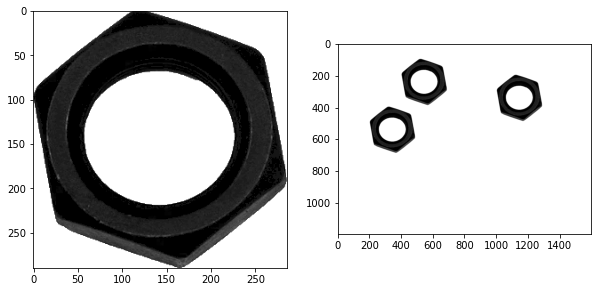

In [ ]:
template_im = cv.imread('/content/drive/MyDrive/ImageProcessing/Assignment_5/template.png', cv.IMREAD_GRAYSCALE) # add the template 
belt_im = cv.imread('/content/drive/MyDrive/ImageProcessing/Assignment_5/belt.png', cv.IMREAD_GRAYSCALE) # add the belt 
fig, ax = plt. subplots(1,2,figsize=(10,10))
ax[0].imshow(template_im, cmap='gray')
ax[1].imshow(belt_im, cmap='gray')
plt.show()

## CV libraries for implementation

**Otsu's thresholding**

Consider an image with only two distinct image values (bimodal image), where the histogram would only consist of two peaks. A good threshold would be in the middle of those two values. Similarly, Otsu's method determines an optimal global threshold value from the image histogram.


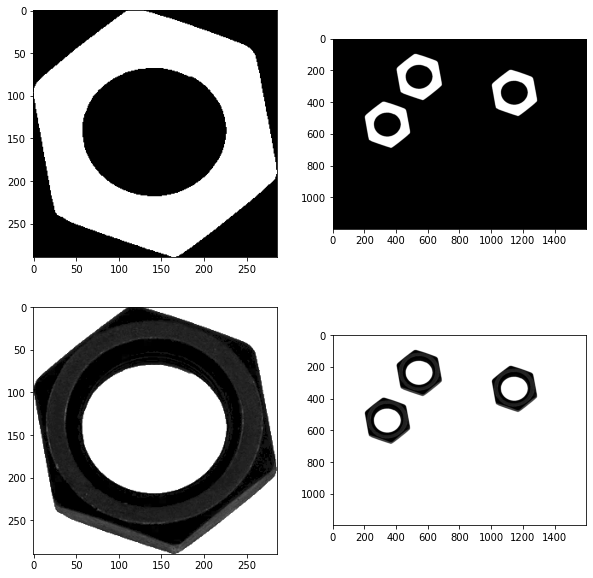

In [ ]:
th_t, img_t = cv.threshold(template_im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU) 
th_b, img_b = cv.threshold(belt_im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
fig, ax = plt. subplots(2,2,figsize=(10,10))
ax[0,0].imshow(img_t, cmap='gray')
ax[1,0].imshow(template_im, cmap='gray')
ax[0,1].imshow(img_b, cmap='gray')
ax[1,1].imshow(belt_im, cmap='gray')
plt.show()

**Morphological closing**

It is useful in closing small holes inside the foreground objects, or small black points on the object.

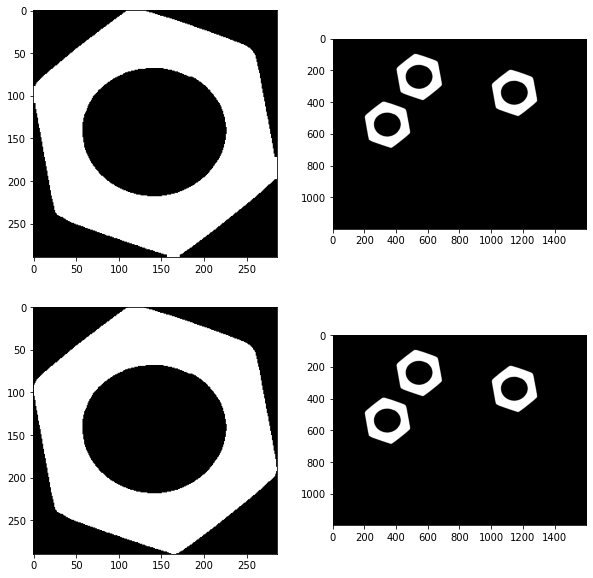

In [ ]:
kernel = np.ones((5,5),np.uint8) #"< 3x3 matrix with all ones, with uint8 dtype>"
closing_t = cv.morphologyEx(img_t, cv.MORPH_CLOSE, kernel)
closing_b = cv.morphologyEx(img_b, cv.MORPH_CLOSE, kernel)
fig, ax = plt. subplots(2,2,figsize=(10,10))
ax[0,0].imshow(closing_t, cmap='gray')
ax[1,0].imshow(img_t, cmap='gray')
ax[0,1].imshow(closing_b, cmap='gray')
ax[1,1].imshow(img_b, cmap='gray')
plt.show()

Connected component analysis

In [ ]:
retval_t, labels_t, stats_t, centroids_t = cv.connectedComponentsWithStats(closing_t)
retval_b, labels_b, stats_b, centroids_b = cv.connectedComponentsWithStats(closing_b)

Counter Analysis

In [ ]:
contours_t, hierarchy_t = cv.findContours(closing_t, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours_b, hierarchy_b = cv.findContours(closing_b, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

 Visualizing contours

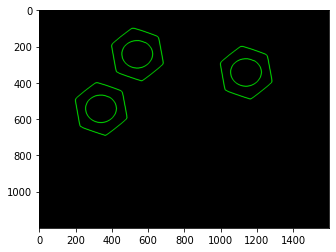

In [ ]:
im_contours_belt = np.zeros((belt_im.shape[0],belt_im.shape[1],3), np.uint8)
conts = cv.drawContours(im_contours_belt, contours_b, -1, (0,255,0), 3).astype('uint8')
plt.imshow(conts)

Count the numbers of matching hexagonal nuts in belt.png

In [ ]:
label = 1 # remember that the label of the background is 0
belt = ((labels_b >= label)*255).astype('uint8')
belt_cont, template_hierarchy = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
for j,c in enumerate(belt_cont):
  print(cv.matchShapes(contours_t[0], c, cv.CONTOURS_MATCH_I1, 0.0))

0.0002170059775208344
0.00021700597752860595
0.00021700597752416506


# Frame tracking through image moments.

In [ ]:
# calculate the area of the contours_b[1]
cnt_b = contours_b[1]
ca = cv.contourArea(cnt_b)
print(ca)

20080.0


In [ ]:
M = cv.moments(cnt_b) #extract the x and y coordinates 
cx, cy = int(M['m10']/M['m00']), int(M['m01']/M['m00'])
print("Centroid = ({}, {})".format(cx,cy))


Centroid = (341, 542)


In [ ]:
# Make a variable called count to represent the number of contours and set it to the value 1. Make an np array [cx, cy, ca, count]
count = 1
object_prev_frame = np.array([cx,cy,count])
print(object_prev_frame)

[341 542   1]


In [ ]:
# define the threshold values 
delta_x = 15

# functions for Implementation

In [ ]:
def get_indexed_image(im):
  th, img = cv.threshold(im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
  kernel = cv.getStructuringElement(cv.MORPH_RECT, (3,3)) 
  closing = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel) # Dilation followed by Erosion
  retval, labels, stats, centroids = cv.connectedComponentsWithStats(closing)
  return retval, labels, stats, centroids

In [ ]:
def is_new(a, b, delta, i):
  abs_diff = np.abs(a-b)
  results=[]
  for index in i:
    #print(abs_diff[:,index])
    abs_diff[:,index] = (abs_diff[:,index]>delta[index])
    results.append(abs_diff[:,index].all())
  results = np.array(results).all()

  return results

In [ ]:
# check is_new  expected answer False
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
              [7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
              [1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])

b = np.array( [7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])
#print(is_new (a,b,delta,i))
assert is_new(a, b, delta, i) == False, " Check the function "

In [ ]:
def prev_index(a, b, delta, i):

  index = -1
  abs_diff = np.absolute(a-b)
  results=[]
  for element in i:
      #print(abs_diff[:,index])
    abs_diff[:,element] = (abs_diff[:,element] <= delta[element])
    result = np.where(abs_diff[:,element])[0]
    results.append(result)

  values,counts = np.unique(results,return_counts=True)
  best_match = values[np.argmax(counts)]
  matching_nut = a[best_match]
  index = matching_nut[-1] # since count keeps the index of a nut.
   
  return index

In [ ]:
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
              [7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
              [1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])

b = np.array( [7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])
# print(prev_index(a,b,delta,i))
assert prev_index(a,b,delta,i) == 1

In [ ]:
from google.colab.patches import cv2_imshow
color_frames = [] # list to store RGB frames

cap = cv.VideoCapture('/content/drive/MyDrive/ImageProcessing/Assignment_5/conveyor_with_rotation.mp4') # give the correct path here
while cap.isOpened(): 
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    color_frames.append(frame)
    #cv.imshow("Frame", frame)
    if cv.waitKey(1) == ord('q'):  
        break
        
cap.release()
cv.destroyAllWindows()

Can't receive frame (stream end?). Exiting ...


# Implementation

1.4 Steps:
1. Use the above code snippet to access each frame and remember to convert the frame into
grey scale. Name the variable as grey
5
2. Call get_indexed_image and extract retval, labels, stats, centroids.
3. Find contours of all nuts present in a given frame of the belt.
4. Initiate a 3-D array with zeros to draw contours. Call this im_contours_belt
5. Draw each contour. Use cv.drawContours. [See this](https://docs.opencv.org/master/d4/d73/tutorial_py_contours_begin.html)

read the Video and save the frame in an array



Video capturing is in progress...
Can't receive frame (stream end?). Exiting ...
Video capturing completed.


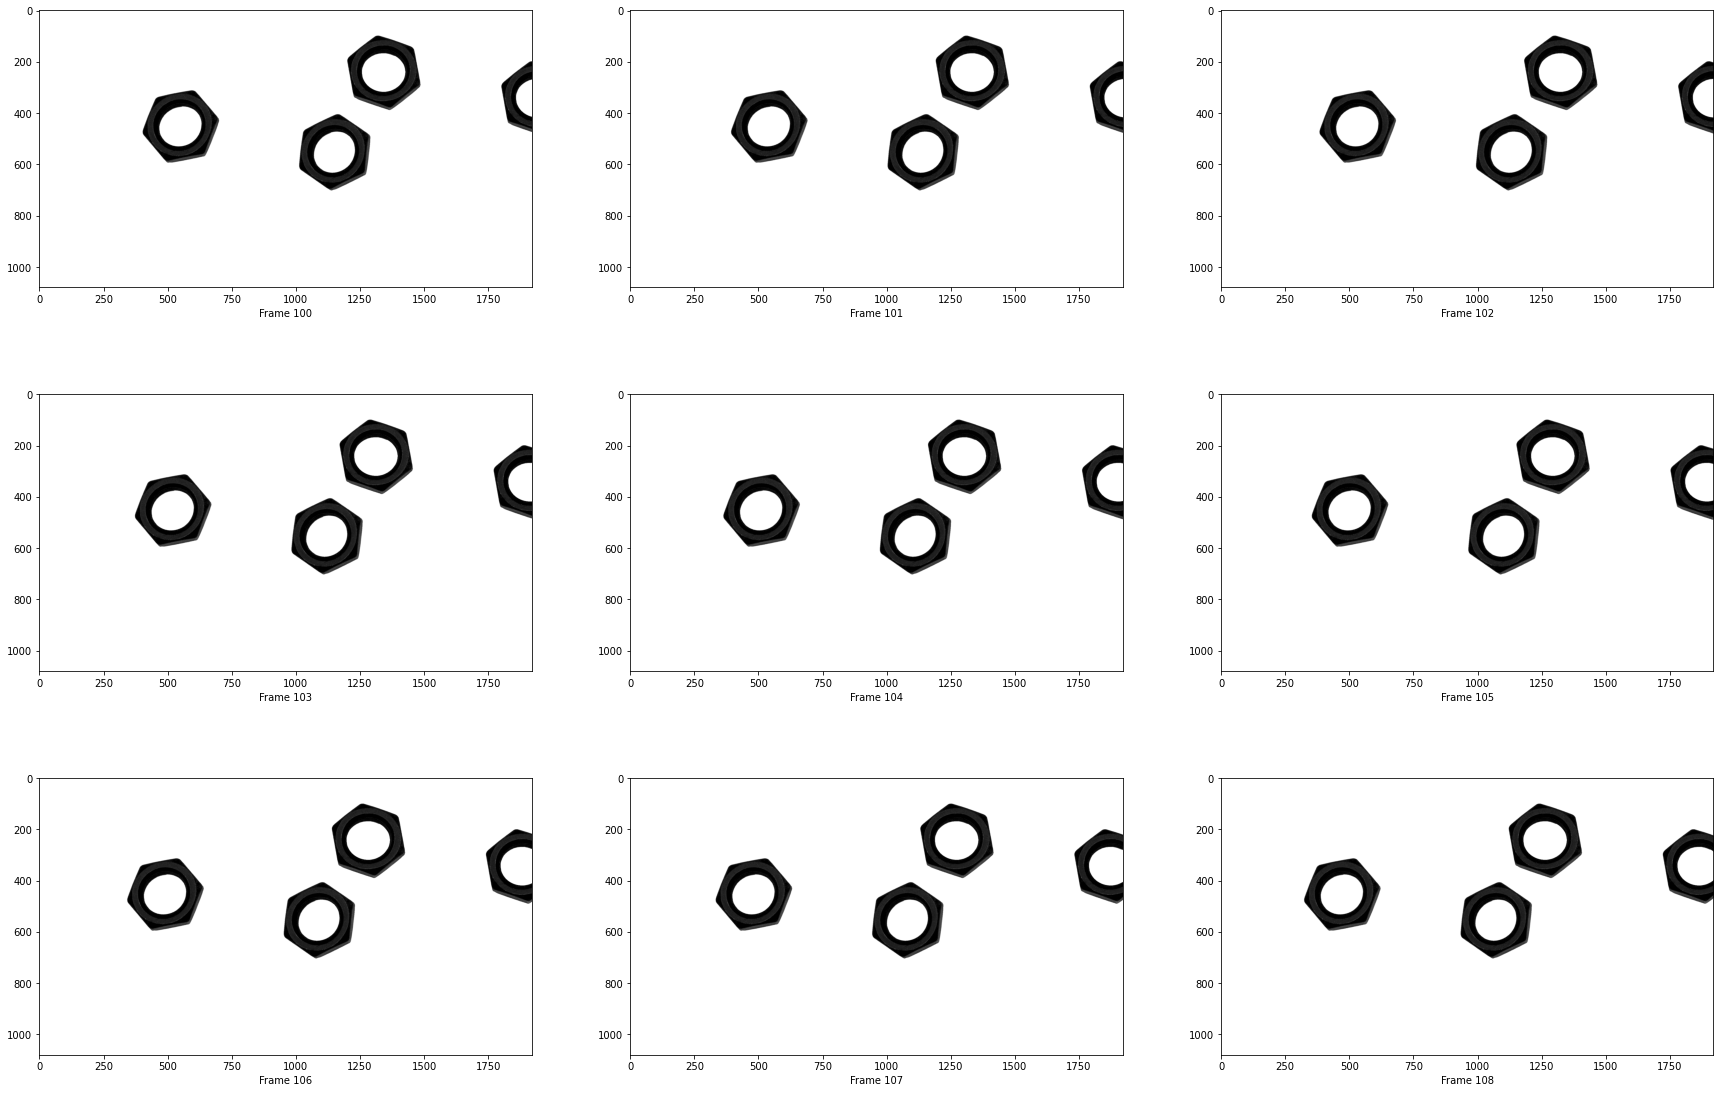

In [ ]:

gray_frames = []  # list to store Gray Scale frames
cap = cv.VideoCapture('/content/drive/MyDrive/ImageProcessing/Assignment_5/conveyor_with_rotation.mp4') # give the correct path here
print("Video capturing is in progress...")
while cap.isOpened(): 
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY) # convert to grayscale
    gray_frames.append(frame) # store the grayscale frame images
    
    if cv.waitKey(1) == ord('q'): #keyboard interruption
        break
        
cap.release()
cv.destroyAllWindows()
print("Video capturing completed.")

# visualizing some of the captured frames
plt.figure(figsize=(30,20))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(gray_frames[100 +i], cmap ='gray')
    plt.xlabel("Frame " + str(100 +i))
plt.show()

Find contours of all nuts present in a given frame of the belt

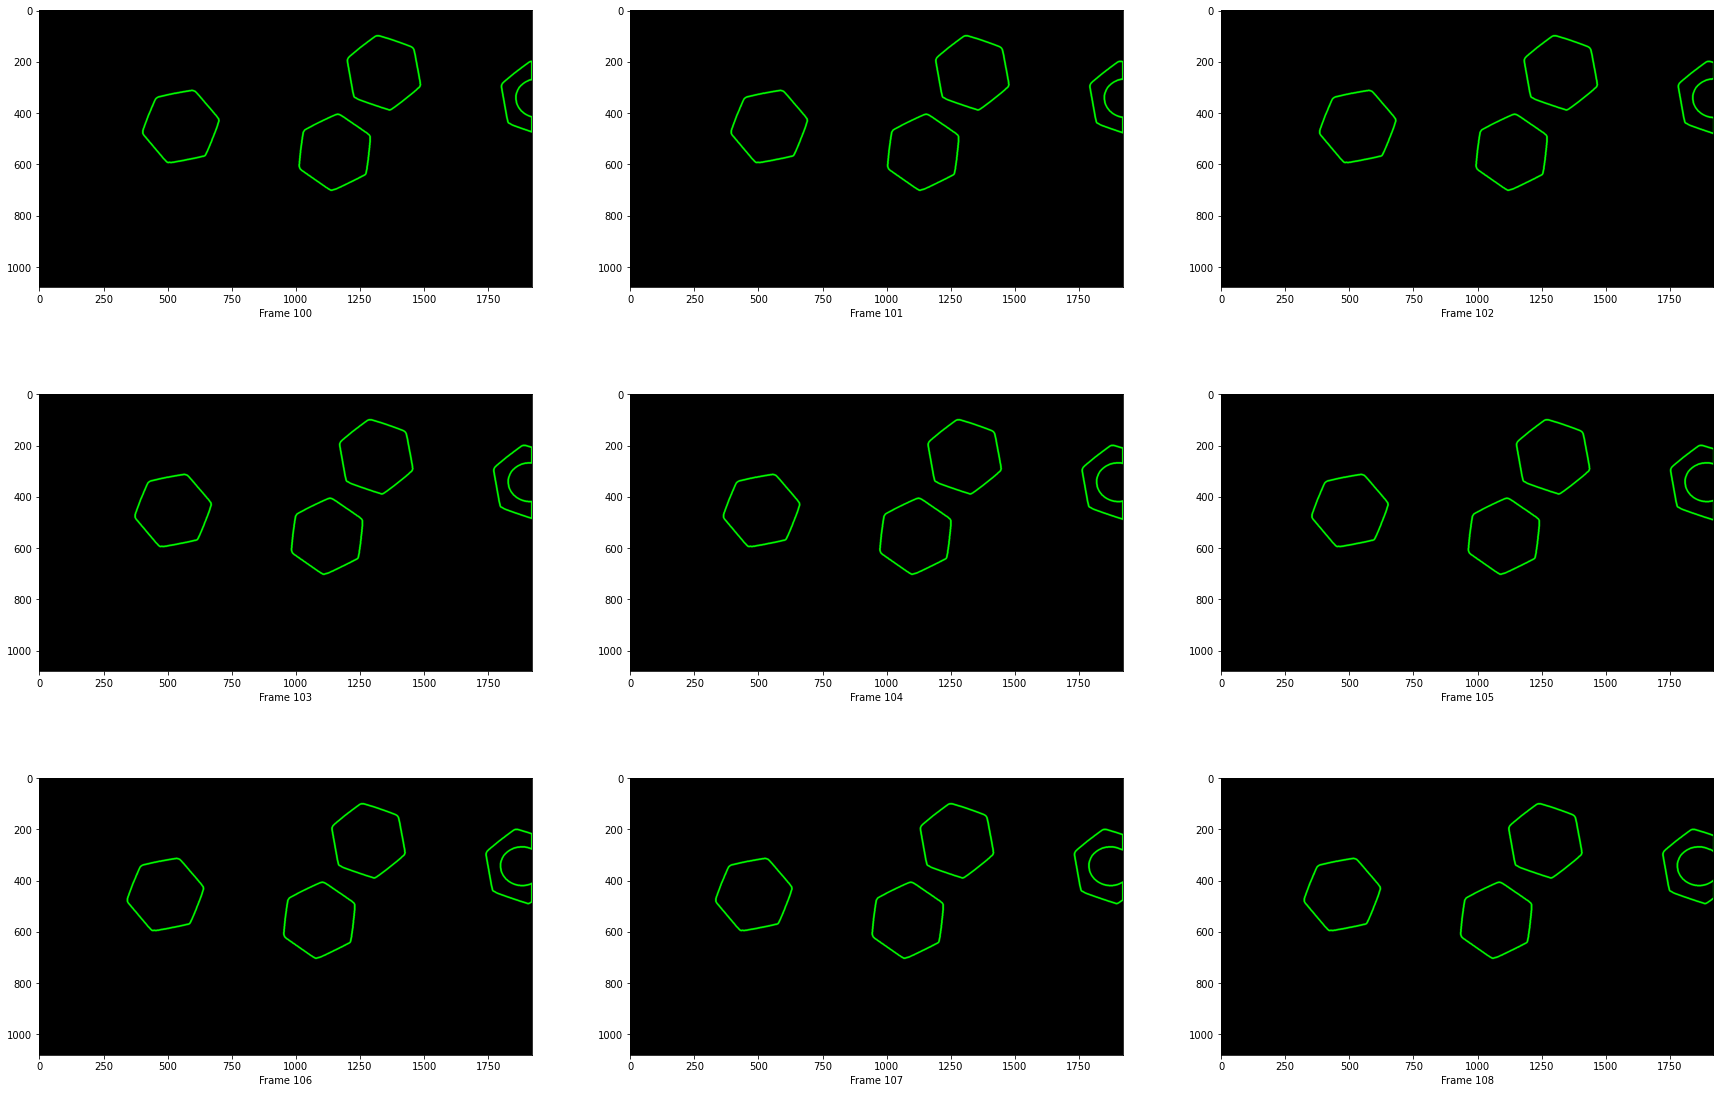

In [ ]:
contour_plots = []
contours_list = []
for gray in gray_frames:
    # finding contours
    _, labels, _, _ = get_indexed_image(gray) # Conn: Comp: Analysis
    belt = ((labels >= 1)*255).astype('uint8') 
    contours,_  = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contours_list.append(contours)
    # plotting contours
    im_contours_belt = np.zeros((belt.shape[0],belt.shape[1],3), np.uint8)
    cont_plot = cv.drawContours(im_contours_belt, contours, -1, (0,255,0), 5).astype('uint8')
    contour_plots.append(cont_plot)

# visualizing some of the contour plots on frames
plt.figure(figsize=(30,20))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(contour_plots[100 +i])
    plt.xlabel("Frame " + str(100 +i))
plt.show()

# Object detection 

frame tracking through image moments.
extracting details about each contour in each frame

In [ ]:

video = []
print("Details extraction is in progress...")
for gray in gray_frames:
    # finding contours
    _, labels, _, _ = get_indexed_image(gray)
    belt = ((labels >= 1)*255).astype('uint8') 
    contours,_  = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    count = 0 # number of nuts in a given frame
    frame = []
    
    for contour in contours:
        metric = cv.matchShapes(contours_t[0], contour, cv.CONTOURS_MATCH_I1, 0.0)
        # Set the matching threshold to be 0.5
        if metric <= 0.5: # if only a complete hexagonal nut
            count +=1
            M  = cv.moments(contour)
            ca = M['m00']
            cx, cy = int(M['m10']/M['m00']), int(M['m01']/M['m00'])
            frame.append(np.array([cx, cy, ca, count]))
    
    video.append(frame)
print("Details extraction completed.")
print(video)

Details extraction is in progress...
Details extraction completed.
[[array([1.55100e+03, 4.53000e+02, 5.99395e+04, 1.00000e+00])], [array([1.54100e+03, 4.53000e+02, 5.99405e+04, 1.00000e+00])], [array([1.53100e+03, 4.53000e+02, 5.99385e+04, 1.00000e+00])], [array([1.52100e+03, 4.53000e+02, 5.99395e+04, 1.00000e+00])], [array([1.51100e+03, 4.53000e+02, 5.99385e+04, 1.00000e+00])], [array([1.50100e+03, 4.53000e+02, 5.99395e+04, 1.00000e+00])], [array([1.49100e+03, 4.53000e+02, 5.99385e+04, 1.00000e+00])], [array([1.48100e+03, 4.53000e+02, 5.99385e+04, 1.00000e+00])], [array([1.47100e+03, 4.53000e+02, 5.99385e+04, 1.00000e+00])], [array([1.46100e+03, 4.53000e+02, 5.99375e+04, 1.00000e+00])], [array([1.45100e+03, 4.53000e+02, 5.99445e+04, 1.00000e+00])], [array([1.44100e+03, 4.53000e+02, 5.99365e+04, 1.00000e+00])], [array([1.43100e+03, 4.53000e+02, 5.99445e+04, 1.00000e+00])], [array([1.42100e+03, 4.53000e+02, 5.99445e+04, 1.00000e+00])], [array([1.41100e+03, 4.53000e+02, 5.99395e+04, 1.0

Nut counter Implemetation

In [ ]:

total_nuts = int(video[0][-1][-1])
print("Number of nuts in the zeroth frame: ",total_nuts)

delta_x = np.array([15])
i = np.array([0])

prev_frame = video[0] # Reference frame to compare with the upcoming frame

for frame_num in range(1, len(video)):
    current_frame = video[frame_num] # frame to be compared    
    
    for nut in current_frame:
        # Checking the current nut with previous frame
        # if it is a new nut count it.
        if is_new(prev_frame, nut, delta_x, i):
            total_nuts +=1  
            
    prev_frame = current_frame
    
print("Total number of nuts found: ",total_nuts)     

Number of nuts in the zeroth frame:  1
Total number of nuts found:  5


trackig nuts: 
An extension of the previous counting nuts algorithm


In [ ]:
# trackig nuts: An extension of the previous counting nuts algorithm
print("Detection and indexing is in progress...")
total_nuts = int(video[0][-1][-1]) #initial number of nuts in frame 0
delta_x = np.array([15])
i = np.array([0])
prev_frame = video[0] # Reference frame to compare with the upcoming frame

for frame_num in range(1, len(video)):
    current_frame = video[frame_num] # frame to be compared
    
    for nut in current_frame:
        # Checking the current nut with previous frame
        # if it is a new nut count it and assign a new index
        if is_new(prev_frame, nut, delta_x, i):
            total_nuts +=1
            nut[-1] = total_nuts # assignment of a new index
        
        else: 
            # to be tracked the nut must not be a new nut
            nut_index = prev_index(prev_frame, nut, delta_x, i)         
            nut[-1] = nut_index # assign the same index it had previously, for old nuts
        
    prev_frame = current_frame
print("Detection and indexing completed.")

frame annotation with the extracted details

In [ ]:
annotated_frames =[]
frame_num = 0
print("Frame annotation is in progress...")
for frame, color_frame, contours in zip(video, color_frames, contours_list):
    
    # Annotation was done on the frames of the original video
    img = color_frame
    y = 0 # to change the vertical position of 'object details' of a frame
    
    for nut in frame:
        # Annotate the nut index
        img = cv.putText(img, str(int(nut[-1])),\
                (int(nut[0]),int(nut[1])),cv.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 4)
        # Annotate the nut(object) details
        img = cv.putText(img, "Object {}: {:04} {:04} {:05}".format(int(nut[-1]), int(nut[0]), int(nut[1]), nut[2]),\
                         (50,850 + 70*y), cv.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 4)
        
        y +=1 # change vertical position for next object details annotation.
    
    # Annotation of the frame number and draw the extracted contours
    img = cv.putText(img, "Frame "+str(frame_num) , (50,750) , cv.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3)
    img = cv.drawContours(img, contours, -1, (255,0,0), 5).astype('uint8')
    
    # Index number 180631J
    img = cv.putText(img, "180330K" , (50,150) , cv.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3)
    annotated_frames.append(img)
    frame_num +=1
print("Frame annotation completed.")

# visulaizing some annotated frames 
plt.figure(figsize=(30,20))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(annotated_frames[100 +i][:,:,::-1])
    plt.xlabel("Frame " + str(100 +i))
plt.show()

Create the video by the frame

In [ ]:
output = '180330K_en2550_a05.mp4' # Name of the output video file.
fourcc = cv.VideoWriter_fourcc(*'MP4V') # 4-character code of codec used to compress the frames
duration = 9 # duration of the source video
fps = int(len(annotated_frames)/duration) # Framerate of the created video stream
height, width,_ = annotated_frames[0].shape
frame_size = (width, height)
isColor = True # to write color images to the video
print('Frame Size(WxH) :', frame_size ,'\nFrames Per Second :', fps)

# Creating the Video Writer object
out = cv.VideoWriter(output, fourcc, fps, frame_size, isColor)
print("Video writer in progress...")
for frame in annotated_frames:
    out.write(frame)

# Release everything if job is finished
out.release()
print("Video writing completed.")

Frame Size(WxH) : (1920, 1080) 
Frames Per Second : 31
Video writer in progress...
Video writing completed.
